In [2]:
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, learning_curve, LearningCurveDisplay

In [3]:
def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def loss(clf, X, y):
    probs = clf.predict_log_proba(X)
    y0 = probs[:,1]
    y1 = probs[:,0]
    loss = -y*y0 - (1-y)*y1
    loss = loss.sum()/y.size
    return loss

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=False)

In [4]:
dataset_1 = load_dataset("domain1_train_data.json")
dataset_2 = load_dataset("domain2_train_data.json")
datatexts_1 = [ sentencify(instance['text']) for instance in dataset_1 ]
datatexts_2 = [ sentencify(instance['text']) for instance in dataset_2 ]

In [5]:
tfidf_vectorizer = get_vectorizer( texts = datatexts_1+datatexts_2,
                                    method='tfidf',
                                    use_idf=True,
                                    ngram_range=(1,1),
                                    max_df=0.9999, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                    min_df=2, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                    )
print(f"no features: {tfidf_vectorizer.get_feature_names_out().size}")

no features: 32659


In [6]:
X = tfidf_vectorizer.transform( datatexts_1 + datatexts_2 ).toarray()
y = np.array( [0]*5000 + [1]*13000 )

In [7]:
mnb_clf = MultinomialNB(alpha=0.0001)

KeyboardInterrupt: 

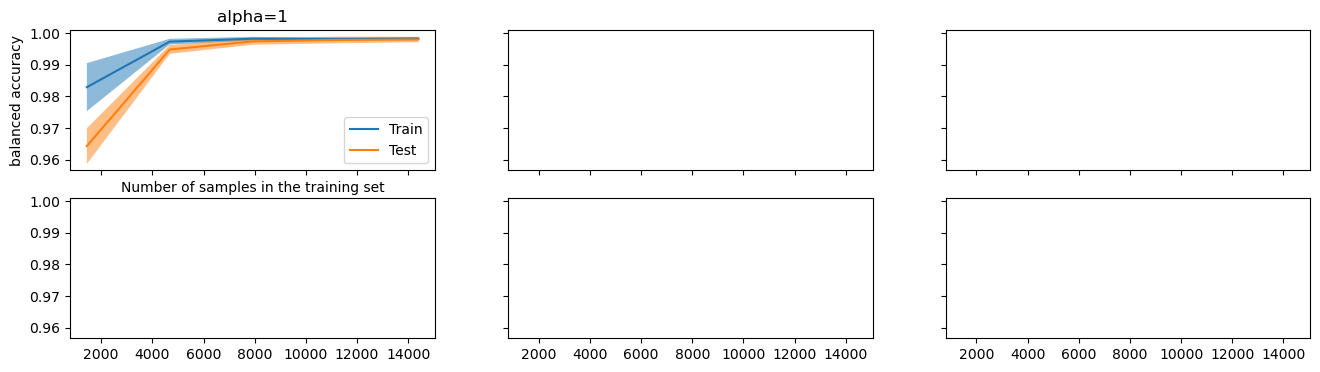

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows = 1, ncols = 3, figsize=(16,4), dpi=100, sharey=True, sharex=True )
for alpha, ax in zip( [1,1e-2,1e-4], axs.reshape(-1) ):
    train_sizes = np.arange(0.2,1.2,0.2)
    pipeline = MultinomialNB(alpha=alpha)
    (train_sizes, 
    train_scores, 
    test_scores) = learning_curve(pipeline, X, y, 
                                  scoring=balanced_acc, 
                                  n_jobs=-1,
                                  shuffle=True,
                                  random_state=0)
    display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores)
    display.plot(ax=ax)
    ax.set_title(f"alpha={alpha}")
    ax.set_ylabel("balanced accuracy")
fig.show()

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_idces, test_idces in cv.split(X, y):
    X_train, y_train = X[train_idces,:], y[train_idces]
    X_test, y_test = X[test_idces,:], y[test_idces]
    mnb_clf.fit(X_train, y_train)
    mnb = balanced_acc( mnb_clf, X_test, y_test )
    print(mnb)

0.9983076923076923
0.9977307692307693
0.9995
0.9978076923076923
0.999


In [25]:
mnb_clf.fit(X,y)

MultinomialNB(alpha=0.0001)

In [26]:
import pickle as pkl
with open("domain_classifier_mnb.mdl", "wb") as f:
    pkl.dump([tfidf_vectorizer, mnb_clf], f)

In [17]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [19]:
clf = LogisticRegression(C=100, random_state=0, n_jobs=-1, class_weight="balanced")

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_idces, test_idces in cv.split(X, y):
    X_train, y_train = X[train_idces,:], y[train_idces]
    X_test, y_test = X[test_idces,:], y[test_idces]
    clf.fit(X_train, y_train)
    mnb = balanced_acc( clf, X_test, y_test )
    print(mnb)

0.9966153846153847
0.9989230769230769
0.9975384615384615
0.9951153846153846
0.9981153846153846


In [27]:
clf = LogisticRegression(C=100, random_state=0, n_jobs=-1, class_weight="balanced")
clf.fit(X,y)

LogisticRegression(C=100, class_weight='balanced', n_jobs=-1, random_state=0)

In [28]:
import pickle as pkl
with open("domain_classifier_lr.mdl", "wb") as f:
    pkl.dump([tfidf_vectorizer, clf], f)